In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytesseract as tess
from sklearn.model_selection import train_test_split
from keras.utils import load_img
from keras.applications import InceptionResNetV2
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [2]:
dataset_path = "./datasets/9-NUMBER-PLATE-RECOGNITION/"
df = pd.read_csv(dataset_path + "labels.csv")
df.head()

,image_path,xmin,xmax,ymin,ymax
0,N1.jpeg,0.569271,0.727083,0.597222,0.673148
1,N100.jpeg,0.297778,0.668889,0.748201,0.839329
2,N101.jpeg,0.124498,0.558233,0.535565,0.673640
3,N102.jpeg,0.343096,0.661088,0.546835,0.615190
4,N103.jpeg,0.451667,0.592778,0.554167,0.603333


In [3]:
def plot_img(path, coords):
    img = load_img(dataset_path + "images/" + path)
    h, w, _ = np.array(img).shape
    x1, x2, y1, y2 = coords * [w, w, h, h]
    plt.imshow(img)
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")
    plt.axis("off")
    plt.show()

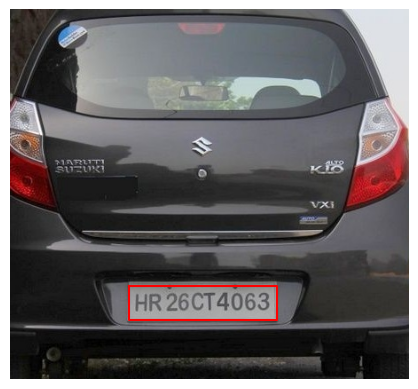

In [4]:
path, coords = df.iloc[1][0], df.iloc[1][1:]
plot_img(path, coords)

In [5]:
data = [np.array(load_img(dataset_path + "images/" + path).resize((224, 224))) / 255.0 for path in df.iloc[:, 0]]
output = df.iloc[:, 1:].values

X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
inception = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in inception.layers[:-5]:
    layer.trainable = False

input_tensor = inception.input
x = inception.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
output_tensor = Dense(4, activation="sigmoid")(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4))

In [ ]:
_ = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), batch_size=16)

In [8]:
test_image = dataset_path + "/TEST/TEST.jpeg"
img = load_img(test_image, target_size=(224, 224))
img = np.array(img) / 255.0
img = np.expand_dims(img,  axis=0)
pred = model.predict(img, verbose=0)

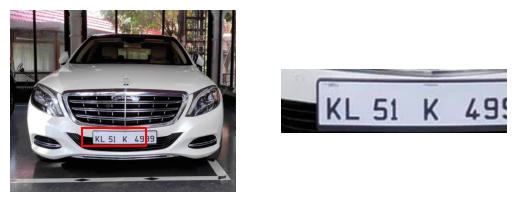

———

a 51 K 49°



In [9]:
img = np.array(load_img(test_image))
h, w, _ = img.shape
coords = pred[0] * [w, w, h, h]
x1, x2, y1, y2 = coords.astype("int")
crop_img = img[y1:y2, x1:x2]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax1.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")
ax1.axis("off")
ax2.imshow(crop_img)
ax2.axis("off")
plt.show()

label = tess.image_to_string(crop_img, lang="eng")
print(label)